In [1]:

from sklearn import datasets
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm   
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import kagglehub
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:

#download dataset
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

#load CSV into a pandas dataframe
dataset = pd.read_csv(f"{path}/dataset.csv")

#verify data
#print(dataset.head())
#print(dataset.shape)

# see the features available
print(list(dataset.columns)) 
#print(dataset.iloc[5])


['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


In [3]:
#pre-processing

#remove duplicates, speech-like tracks and rows with missing entries
dataset = dataset.drop_duplicates(subset=["track_name", "artists"], keep="first")
dataset = dataset[dataset['speechiness'] <= 0.66]
dataset = dataset.dropna() 

#subset for selected features
selected_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'valence', 'tempo','popularity'
]

#group micro-genres into 10 macro-genres
genre_groups = {
    "pop": ['pop', 'indie-pop', 'synth-pop', 'k-pop'],
    "rock": ['rock', 'alt-rock', 'hard-rock', 'punk-rock', 'psych-rock',
             'rock-n-roll', 'grunge', 'rockabilly', 'j-rock', 'garage'],
    "electronic": ['electronic', 'electro', 'deep-house', 'techno', 'trance',
                   'minimal-techno', 'house', 'progressive-house',
                   'dubstep', 'drum-and-bass'],
    "classical": ['classical', 'opera'],
    "metal": ['metal', 'heavy-metal', 'black-metal', 'death-metal', 'metalcore'],
    "jazz": ['blues', 'soul','jazz'],
    "hip-hop": ['hip-hop'],
    "country": ['country'],
    "latin": ['latin', 'reggaeton', 'latino', 'salsa', 'tango', 'spanish'],
    "folk": ['folk', 'acoustic', 'singer-songwriter']
}

#map every micro-genre in the dataset to its macro-genre
def map_macro_genre(genre):
    for macro, subs in genre_groups.items():
        if genre in subs:
            return macro
    return None  # if not in any group, remain unmapped

#subset for selected genres
dataset['macro_genre'] = dataset['track_genre'].apply(map_macro_genre)
dataset = dataset[dataset['macro_genre'].notnull()]  # keep only mapped ones

X = dataset[selected_features].values
y = dataset['macro_genre'].values

#create labels for the genres
le = LabelEncoder()
y_id = le.fit_transform(y)
num_genres = len(le.classes_)

#display number of samples per selected genre
genre_samples_count = dataset["macro_genre"].value_counts()
print("Number of samples per genre:")
print(genre_samples_count)
print("\nTotal number of samples", len(y_id))

Number of samples per genre:
macro_genre
rock          6122
electronic    6001
metal         3742
latin         3568
pop           2324
folk          2117
classical     1567
jazz          1177
hip-hop        659
country        570
Name: count, dtype: int64

Total number of samples 27847


In [4]:

#split proportions
test_size = 0.15
val_size = 0.15

#split into train (.7) and temp (.3)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_id, test_size=(test_size + val_size), random_state=42,
)

#split temp into validation (.15) and test (.15)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(test_size / (test_size + val_size)), random_state=42,
)

print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))



Train: 19492
Validation: 4177
Test: 4178


In [5]:
scaler=StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [6]:
#hyperparameters
embedding_dim = 5
num_epochs = 200
learning_rate = 0.00005
dropout = 0.1
batch_size = 128

#data conversion to PyTorch tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
X_val = torch.tensor(X_val, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.long)

#create dataset and loader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [7]:
#genre encoder (y -> z)
class GenreEncoder(nn.Module):
    def __init__(self, num_genres, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_genres, embedding_dim)

    def forward(self, genre_id):
        if genre_id.dim() == 2 and genre_id.size(1) == 1:
            genre_id = genre_id.squeeze(1)
        z = self.embedding(genre_id)  # [batch, embedding_dim]
        return z

#feature encoder (x -> ẑ)
class FeatureEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, dropout_prob = 0.3):
        super().__init__()
        self.input = nn.Linear (input_dim, 64)
        self.hidden1 = nn.Linear (64, 64)
        self.hidden2 = nn.Linear (64, 64)
        self.out = nn.Linear (64, embedding_dim)
        self.dropout = nn.Dropout (p = dropout_prob)


    def forward(self, x):
        x = F.relu (self.input(x)); x = self.dropout(x)

        x = F.relu (self.hidden1(x)); x = self.dropout(x)

        x = F.relu (self.hidden2(x)); x = self.dropout(x)

        z_hat = self.out(x)
        return z_hat

genre_embedding = GenreEncoder(num_genres, embedding_dim)

model = FeatureEncoder(
    input_dim = X_train.shape[1], 
    embedding_dim = embedding_dim, dropout_prob = dropout
)

#loss
criterion = nn.CosineSimilarity(dim=1)

#optimizer
optimizer = optim.Adam(
    list(model.parameters()) + list(genre_embedding.parameters()),
    lr = learning_rate
)

In [8]:
model.train()
genre_embedding.train()

for epoch in range(num_epochs):
    
    total_loss = 0.0

    for x_feat, y_genre in train_dataloader:
        optimizer.zero_grad()
        
        z = genre_embedding(y_genre)
        
        z_hat = model(x_feat)

        cos_sim = criterion( z_hat, z)
        loss = 1 - cos_sim.mean()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.10f}")
    

Epoch 1/200 | Loss: 0.6595335369
Epoch 2/200 | Loss: 0.5440031461
Epoch 3/200 | Loss: 0.5004087515
Epoch 4/200 | Loss: 0.4594039333
Epoch 5/200 | Loss: 0.4390692088
Epoch 6/200 | Loss: 0.4213930696
Epoch 7/200 | Loss: 0.4106953810
Epoch 8/200 | Loss: 0.4030003587
Epoch 9/200 | Loss: 0.3935789061
Epoch 10/200 | Loss: 0.3871965930
Epoch 11/200 | Loss: 0.3826758028
Epoch 12/200 | Loss: 0.3756148441
Epoch 13/200 | Loss: 0.3703804043
Epoch 14/200 | Loss: 0.3630490206
Epoch 15/200 | Loss: 0.3606403365
Epoch 16/200 | Loss: 0.3543109243
Epoch 17/200 | Loss: 0.3494097419
Epoch 18/200 | Loss: 0.3440103395
Epoch 19/200 | Loss: 0.3416248770
Epoch 20/200 | Loss: 0.3372597429
Epoch 21/200 | Loss: 0.3312168900
Epoch 22/200 | Loss: 0.3279813657
Epoch 23/200 | Loss: 0.3224545577
Epoch 24/200 | Loss: 0.3185506981
Epoch 25/200 | Loss: 0.3143670878
Epoch 26/200 | Loss: 0.3102201847
Epoch 27/200 | Loss: 0.3057849438
Epoch 28/200 | Loss: 0.3023222373
Epoch 29/200 | Loss: 0.2985410608
Epoch 30/200 | Loss: 0.

In [9]:
#classification report

model.eval()
genre_embedding.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for x_feat, y_genre in train_dataloader:  # or test_dataloader if you prefer
        # Ground truth genre indices
        y_true.extend(y_genre.cpu().numpy())

        # Predicted embedding from model
        z_hat = model(x_feat)

        # Get genre embeddings from trained embedding layer
        Z = genre_embedding.embedding.weight.data  # shape [num_genres, embed_dim]

        # Compute cosine similarities between predicted z_hat and all genres
        cos_sim = F.cosine_similarity(
            z_hat.unsqueeze(1), Z.unsqueeze(0), dim=-1
        )  # shape [batch_size, num_genres]

        # Take the index of the most similar genre as prediction
        y_pred_batch = cos_sim.argmax(dim=1).cpu().numpy()
        y_pred.extend(y_pred_batch)

print("\nClassification Report:")
print(classification_report(y_true, y_pred,target_names=le.classes_))

#confusion matrix

K = 10
counts_all = pd.Series(y_true).value_counts()
topK_ids = counts_all.index[:K].to_numpy()
topK_names = le.inverse_transform(topK_ids)

#filter data
mask = np.isin(y_true, topK_ids)
y_true_top = np.array(y_true)[mask]
y_pred_top = np.array(y_pred)[mask]

cm_top = confusion_matrix(y_true_top, y_pred_top, labels=topK_ids)
cm_df = pd.DataFrame(cm_top, index=topK_names, columns=topK_names)
print("\nConfusion Matrix:\n")
print(cm_df)


Classification Report:
              precision    recall  f1-score   support

   classical       0.91      0.71      0.80      1108
     country       0.00      0.00      0.00       401
  electronic       0.53      0.70      0.60      4217
        folk       0.22      0.68      0.33      1502
     hip-hop       0.15      0.43      0.22       482
        jazz       1.00      0.00      0.00       799
       latin       0.86      0.18      0.29      2465
       metal       0.75      0.66      0.70      2626
         pop       0.19      0.32      0.24      1643
        rock       0.59      0.20      0.30      4249

    accuracy                           0.44     19492
   macro avg       0.52      0.39      0.35     19492
weighted avg       0.58      0.44      0.43     19492


Confusion Matrix:

            rock  electronic  metal  latin  pop  folk  classical  jazz  \
rock         871        1006    272     29  816  1133         11     0   
electronic    88        2952    133      4  530  

C:\Users\marta\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marta\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marta\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

C:\Users\marta\AppData\Local\Temp\ipykernel_36444\2332049811.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', K)


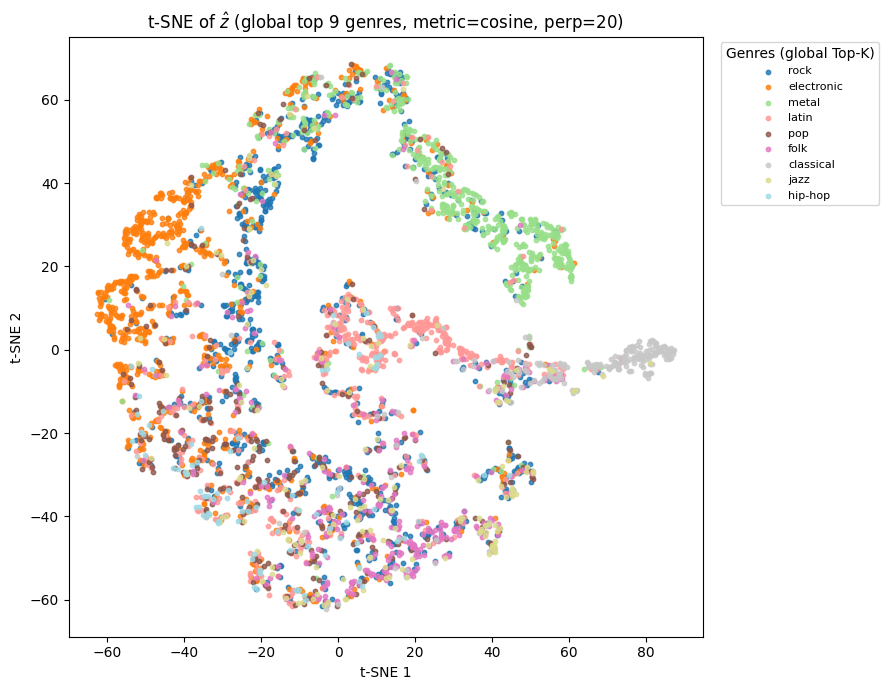

In [ ]:
#visualizar os K generos mais frequentes

model.eval(); genre_embedding.eval()

with torch.no_grad():
    Zhat_val = model(X_val).cpu().numpy()
    y_val_np = y_val.cpu().numpy()

#top-K genres
K = 9
counts_all = pd.Series(y_id).value_counts()
topK_ids = counts_all.index[:K].to_numpy()
topK_names = le.inverse_transform(topK_ids)

# filter validation to those K
mask = np.isin(y_val_np, topK_ids)
Z = Zhat_val[mask]
y_small = y_val_np[mask]

# subsample for speed if needed
rng = np.random.RandomState(42)
max_points = 4000
if len(Z) > max_points:
    id = rng.choice(len(Z), size=max_points, replace=False)
    Z = Z[id]; y_small = y_small[id]

# normalize (cosine), PCA -> t-SNE
Zn = Z / (np.linalg.norm(Z, axis=1, keepdims=True) + 1e-12)
pca = PCA(n_components=min(50, Z.shape[1]), random_state=42)
Zp = pca.fit_transform(Zn)

perp = min(50, max(5, len(Zp)//200))
tsne = TSNE(n_components=2, perplexity=perp, learning_rate='auto',
            init='pca', metric='cosine', random_state=42)
Z2 = tsne.fit_transform(Zp)

#plot
cmap = cm.get_cmap('tab10', K)
plt.figure(figsize=(9,7))
for i, gid in enumerate(topK_ids):
    m = (y_small == gid)
    plt.scatter(Z2[m,0], Z2[m,1], s=10, color=cmap(i), alpha=0.8, label=topK_names[i])
plt.legend(title="Genres (global Top-K)", bbox_to_anchor=(1.02,1), loc="upper left", fontsize=8)
plt.title(f"t-SNE of $\\hat{{z}}$ (global top {K} genres, metric=cosine, perp={perp})")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout(); plt.show()

In [11]:
#fuzzy c-means clustering 

# ---- Extract genre embeddings after training ----
genre_embedding.eval()
Zgenres = genre_embedding.embedding.weight.detach().cpu().numpy()   #[num_genres, embedding_dim]

# ---- Normalize (cosine geometry) ----
Zg = Zgenres / (np.linalg.norm(Zgenres, axis=1, keepdims=True) + 1e-12)

# ---- Fuzzy C-Means clustering ----
c = 5       # number of broad clusters
m = 2.0      # fuzziness parameter
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Zg.T, c=c, m=m, error=1e-6, maxiter=1000, init=None, seed=42
)
print(f"Fuzzy partition coefficient (FPC): {fpc:.3f}")

# ---- Hard cluster assignment + confidence ----
labels_hard = u.argmax(axis=0)    # cluster index for each genre
labels_conf = u.max(axis=0)       # highest membership value (confidence)

# ---- Build table: micro-genre -> cluster info ----
genre_names_all = le.classes_
df_clusters = pd.DataFrame({
    "genre": genre_names_all,
    "cluster": labels_hard,
    "membership": labels_conf
}).sort_values(["cluster", "membership"], ascending=[True, False]).reset_index(drop=True)

print("\nTop rows of fuzzy cluster mapping:")
print(df_clusters.head(110))

# ---- Map every song's genre ID to its cluster ID ----
cluster_of_genre = labels_hard
y_train_cluster = cluster_of_genre[y_train.cpu().numpy()]
y_val_cluster   = cluster_of_genre[y_val.cpu().numpy()]
y_test_cluster  = cluster_of_genre[y_test]

print(df_clusters['cluster'].value_counts().sort_index())


Fuzzy partition coefficient (FPC): 0.967

Top rows of fuzzy cluster mapping:
        genre  cluster  membership
0        jazz        0    1.000000
1     country        1    1.000000
2   classical        2    1.000000
3       metal        3    0.999987
4         pop        4    0.989049
5  electronic        4    0.984516
6        folk        4    0.974516
7     hip-hop        4    0.971199
8        rock        4    0.960056
9       latin        4    0.951203
cluster
0    1
1    1
2    1
3    1
4    6
Name: count, dtype: int64


C:\Users\marta\AppData\Local\Temp\ipykernel_36444\1998990321.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', c)


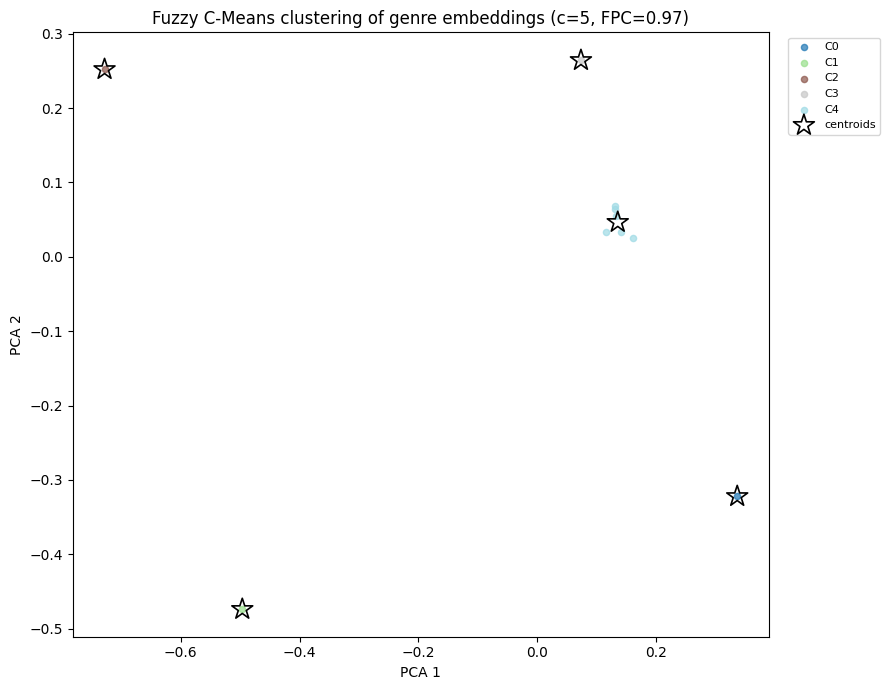

In [12]:
#%% Visualization of fuzzy clusters

# Project the genre embeddings (Zg) to 2D with PCA
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Zg)          # shape [num_genres, 2]
C2 = pca.transform(cntr)            # cluster centers [c, 2]

plt.figure(figsize=(9,7))
cmap = plt.cm.get_cmap('tab20', c)

# Plot each genre embedding colored by its hard cluster
for k in range(c):
    m = (labels_hard == k)
    plt.scatter(Z2[m,0], Z2[m,1], s=20, color=cmap(k), alpha=0.7, label=f"C{k}")

# Plot cluster centroids
plt.scatter(C2[:,0], C2[:,1], s=250, marker='*', edgecolor='k', facecolor='none', linewidths=1.2, label='centroids')

plt.title(f"Fuzzy C-Means clustering of genre embeddings (c={c}, FPC={fpc:.2f})")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


In [13]:
#mlp classifier

# Convert to tensors
y_train_cluster = torch.tensor(y_train_cluster, dtype=torch.long)
y_val_cluster = torch.tensor(y_val_cluster, dtype=torch.long)
y_test_cluster = torch.tensor(y_test_cluster, dtype=torch.long)

train_dataset_cls = TensorDataset(X_train, y_train_cluster)
val_dataset_cls = TensorDataset(X_val, y_val_cluster)
test_dataset_cls = TensorDataset(X_test, y_test_cluster)

train_loader_cls = DataLoader(train_dataset_cls, batch_size=64, shuffle=True)
val_loader_cls   = DataLoader(val_dataset_cls, batch_size=64)
test_loader_cls  = DataLoader(test_dataset_cls, batch_size=64)

# ---- Define the MLP model ----
class GenreClusterClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, num_clusters=K, dropout_prob=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_clusters)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.fc3(x)
        return out

# ---- Initialize model ----
K = len(np.unique(y_train_clusters))  # number of fuzzy clusters
clf_model = GenreClusterClassifier(input_dim=X_train.shape[1], num_clusters=K)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.parameters(), lr=1e-3)

# ---- Training loop ----
num_epochs = 30
for epoch in range(num_epochs):
    clf_model.train()
    total_loss = 0.0
    for xb, yb in train_loader_cls:
        optimizer.zero_grad()
        preds = clf_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader_cls)

    # Validation accuracy
    clf_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader_cls:
            preds = clf_model(xb)
            _, predicted = torch.max(preds, 1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    val_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {avg_loss:.4f}  |  Val Acc: {val_acc:.2f}%")

# ---- Final test evaluation ----
clf_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader_cls:
        preds = clf_model(xb)
        _, predicted = torch.max(preds, 1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)
test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

TypeError: 'int' object is not callable

In [ ]:
#mlp classifier
import torch

# Inputs and labels already exist:
# X_train, X_val, X_test
# y_train_cluster, y_val_cluster, y_test_cluster

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Convert to tensors
y_train_cluster = torch.tensor(y_train_cluster, dtype=torch.long)
y_val_cluster   = torch.tensor(y_val_cluster, dtype=torch.long)
y_test_cluster  = torch.tensor(y_test_cluster, dtype=torch.long)

# Combine training and validation for simplicity
X_all = torch.cat([X_train, X_val], dim=0)
y_all = torch.cat([y_train_cluster, y_val_cluster], dim=0)

# Create dataset and loader
dataset = TensorDataset(X_all, y_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model definition
input_dim = X_train.shape[1]
K = len(np.unique(y_all.numpy()))

model = nn.Sequential(
    nn.Linear(input_dim, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, K)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/len(loader):.4f}")

# Test accuracy
model.eval()
with torch.no_grad():
    preds = model(X_test)
    predicted = preds.argmax(1)
    acc = (predicted == y_test_cluster).float().mean().item() * 100
print(f"\nTest Accuracy: {acc:.2f}%")

C:\Users\marta\AppData\Local\Temp\ipykernel_37048\299788767.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_cluster = torch.tensor(y_train_cluster, dtype=torch.long)
C:\Users\marta\AppData\Local\Temp\ipykernel_37048\299788767.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_cluster   = torch.tensor(y_val_cluster, dtype=torch.long)
C:\Users\marta\AppData\Local\Temp\ipykernel_37048\299788767.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_cluster  = torch.tensor(y_test_cluster, dtype=torch.long)


Epoch 1/20 | Loss: 1.0549
Epoch 2/20 | Loss: 1.0105
Epoch 3/20 | Loss: 0.9945
Epoch 4/20 | Loss: 0.9866
Epoch 5/20 | Loss: 0.9828
Epoch 6/20 | Loss: 0.9778
Epoch 7/20 | Loss: 0.9745
Epoch 8/20 | Loss: 0.9735
Epoch 9/20 | Loss: 0.9714
Epoch 10/20 | Loss: 0.9701
Epoch 11/20 | Loss: 0.9682
Epoch 12/20 | Loss: 0.9659
Epoch 13/20 | Loss: 0.9659
Epoch 14/20 | Loss: 0.9642
Epoch 15/20 | Loss: 0.9633
Epoch 16/20 | Loss: 0.9628
Epoch 17/20 | Loss: 0.9619
Epoch 18/20 | Loss: 0.9613
Epoch 19/20 | Loss: 0.9611
Epoch 20/20 | Loss: 0.9592


TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray